In [11]:
import importlib
import functions

importlib.reload(functions)


<module 'functions' from 'c:\\Users\\sinha\\Documents\\GitHub\\lfp\\cpl_analysis\\functions.py'>

## 02 Loading the folder that contains our data

In [12]:
import glob
files = glob.glob(r'C:\Users\sinha\Dropbox\CPLab\all_data_mat_filtered\*.mat')
print(files)

['C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230529_dk1_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230529_dk3_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230529_dk5_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230529_dk6_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230531_dk1_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230531_dk3_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230531_dk5_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230531_dk6_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230609_dk1_BW_nocontext_day1.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230609_dk3_BW_nocontext_day1.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_filtered\\20230610_dk1_BW_nocontext_day2.mat'

In [13]:
keyboard_dict={'98':'b','119':'w','120':'nc','49':'1','48':'0'}

In [14]:
import os

for file in files:
    # Initialize an empty DataFrame to store the results for all epochs
    ## Get the date, mouse_id and task from the file name
    #compiled_data_all_epochs = pd.DataFrame()

    base_name = os.path.basename(file)
    base_name, _ = os.path.splitext(base_name)

    date, mouse_id, task=functions.exp_params(base_name)
    print(date, mouse_id, task)
    ## Open the file
    f=h5py.File(file, 'r')        
    channels = list(f.keys())
    print(channels)


20230529 dk1 nocontext
['Keyboard', 'LFP1_AON', 'LFP1_vHp', 'LFP2_AON', 'LFP2_vHp', 'LFP3_AON', 'LFP4_AON', 'Ref', 'Respirat', 'file']
20230529 dk3 nocontext
['Keyboard', 'Ref', 'Respirat', 'file']
20230529 dk5 nocontext
['Keyboard', 'LFP1_AON', 'LFP1_vHp', 'LFP2_AON', 'LFP2_vHp', 'LFP3_AON', 'LFP4_AON', 'Ref', 'Respirat', 'file']
20230529 dk6 nocontext
['LFP1_AON', 'LFP1_vHp', 'LFP2_AON', 'LFP2_vHp', 'LFP3_AON', 'LFP4_AON', 'Memory', 'Ref', 'Respirat', 'file']
20230531 dk1 nocontextday2
['Keyboard', 'LFP1_AON', 'LFP1_vHp', 'LFP2_AON', 'LFP2_vHp', 'LFP3_AON', 'LFP4_AON', 'Ref', 'Respirat', 'file']
20230531 dk3 nocontextday2
['Keyboard', 'Ref', 'Respirat', 'file']
20230531 dk5 nocontextday2
['Keyboard', 'LFP1_AON', 'LFP1_vHp', 'LFP2_AON', 'LFP2_vHp', 'LFP3_AON', 'LFP4_AON', 'Ref', 'Respirat', 'file']
20230531 dk6 nocontextday2
['LFP1_AON', 'LFP1_vHp', 'LFP2_AON', 'LFP2_vHp', 'LFP3_AON', 'LFP4_AON', 'Memory', 'Ref', 'Respirat', 'file']
20230609 dk1 BWnocontext
['LFP1_vHp', 'LFP2_vHp', 'L

## 03  Looping through all the data files

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd

#files=['C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230610_dk3_BW_nocontext_day2.mat']
events_codes_all = {}
compiled_data_all_epochs = pd.DataFrame()

for file in files:
    # Initialize an empty DataFrame to store the results for all epochs
    ## Get the date, mouse_id and task from the file name
    #compiled_data_all_epochs = pd.DataFrame()

    base_name = os.path.basename(file)
    base_name, _ = os.path.splitext(base_name)

    date, mouse_id, task=functions.exp_params(base_name)
    print(date, mouse_id, task)
    ## Open the file
    f=h5py.File(file, 'r')
    try:
        channels = list(f.keys())
        print(channels)

        if 'Keyboard' in channels:
            events = f['Keyboard']
        elif 'keyboard' in channels:
            events = f['keyboard']
        elif 'memory' in channels:
            events = f['memory']
        elif 'Memory' in channels:
            events = f['Memory']

        events_codes=np.array(events['codes'][0])
        events_times=np.array(events['times'][0])
        events_codes_all[base_name] = events_codes
        #Generating epochs from events (epochs are basically start of a trial and end of a trial)
        epochs=functions.generate_epochs_with_first_event(events_codes, events_times)

        # Experiment Start time
        first_event=events_times[0]

        for channeli in channels:
            if "AON" in channeli or  "vHp" in channeli :
                
                channel_id=channeli
                
                # Extracting raw data and time
                data_all=f[channeli]
                raw_data=np.array(data_all['values']).flatten()
                raw_time = np.array(data_all['times']).flatten()
                sampling_rate = int(1/data_all['interval'][0][0])
                print(raw_data.shape, raw_time.shape, sampling_rate)
                
                # Normalizing the data by subtracting the mean and std of data 30sec before the first event
                normalized_data,time=functions.data_normalization(raw_data,raw_time,first_event, sampling_rate)

                
                # Applying a notch filter
                notch_filtered_data=functions.iir_notch(normalized_data, sampling_rate,60)
                total=notch_filtered_data
                
                # Extracting the bands
                beta=functions.beta_band(notch_filtered_data, sampling_rate)
                gamma=functions.gamma_band(notch_filtered_data, sampling_rate)
                theta=functions.theta_band(notch_filtered_data, sampling_rate)

                all_bands=[total,beta, gamma, theta]

                for i,epochi in enumerate(epochs):
                    compiled_data = pd.DataFrame()

                    trial_timestamp = epochi[0][0]
                    trial_type = epochi[0][1]
                    dig_type = epochi[1, 1]
                    print(dig_type)
                    dig_timestamp = epochi[1, 0]
                    print(trial_timestamp,trial_type,dig_timestamp,dig_type)
                    for bandi in all_bands:
                        data_trial_before, data_trial_after=functions.extract_trial_data(bandi,time,trial_timestamp,sampling_rate)
                        data_dig_before, data_dig_after=functions.extract_dig_data(bandi,time,dig_timestamp,sampling_rate)

                                            # Create a DataFrame for the current bandi
                        bandi_data = pd.DataFrame({
                            'data_trial_before': [functions.calculate_power_1D(data_trial_before)],
                            'data_trial_after': [functions.calculate_power_1D(data_trial_after)],
                            'data_dig_before': [functions.calculate_power_1D(data_dig_before)],
                            'data_dig_after': [functions.calculate_power_1D(data_dig_after)]
                        })
                        
                        # Concatenate the current bandi DataFrame with the compiled_data DataFrame along axis=1
                        compiled_data = pd.concat([compiled_data, bandi_data], axis=1)
                    compiled_data.columns = ['total_power_pre_door', 'total_power_post_door', 'total_power_pre_odor', 'total_power_post_odor',
                                'beta_power_pre_door', 'beta_power_post_door', 'beta_power_pre_odor', 'beta_power_post_odor',
                                'gamma_power_pre_door', 'gamma_power_post_door', 'gamma_power_pre_odor', 'gamma_power_post_odor',
                                'theta_power_pre_door', 'theta_power_post_door', 'theta_power_pre_odor', 'theta_power_post_odor']
                    compiled_data.insert(0, 'rat', mouse_id)
                    compiled_data.insert(1, 'date', date)
                    compiled_data.insert(2, 'experiment', task)
                    compiled_data.insert(3, 'channel', channel_id)
                    compiled_data.insert(4, 'trial', i)
                    compiled_data.insert(5, 'side', keyboard_dict[str(int(trial_type))])
                    compiled_data.insert(6, 'correct?', keyboard_dict[str(int(dig_type))])

                    compiled_data_all_epochs = pd.concat([compiled_data_all_epochs, compiled_data], axis=0, ignore_index=True)
    finally:
        f.close()
compiled_data_all_epochs.to_csv('compiled_data.csv', index=False)


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the compiled data
compiled_data_all_epochs = pd.read_csv('compiled_data.csv')

# Filter the DataFrame for the required rows
filtered_data = compiled_data_all_epochs[compiled_data_all_epochs['experiment'].isin(['BWnocontext', 'nocontext', 'BWcontext'])]

# Melt the DataFrame to long format
melted_data = pd.melt(filtered_data, id_vars=['experiment'], value_vars=['total_power_pre_door', 'total_power_post_door', 'total_power_pre_odor', 'total_power_post_odor'], var_name='PowerType', value_name='PowerValue')
# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from the melted data
melted_data = melted_data.groupby('PowerType').apply(lambda x: remove_outliers(x, 'PowerValue')).reset_index(drop=True)


C:\Users\sinha\AppData\Local\Temp\ipykernel_36820\3589640883.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  melted_data = melted_data.groupby('PowerType').apply(lambda x: remove_outliers(x, 'PowerValue')).reset_index(drop=True)


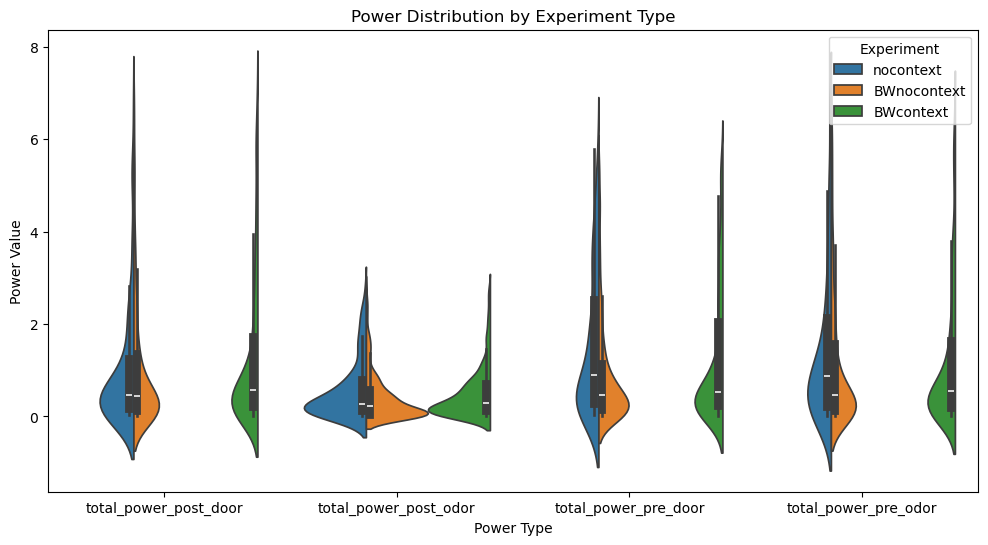

In [10]:
import seaborn as sns

# Create the violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='PowerType', y='PowerValue', hue='experiment', data=melted_data, split=True)
plt.title('Power Distribution by Experiment Type')
plt.xlabel('Power Type')
plt.ylabel('Power Value')
plt.legend(title='Experiment')
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the compiled data
compiled_data_all_epochs = pd.read_csv('compiled_data.csv')

# Filter the DataFrame for the required rows
filtered_data = compiled_data_all_epochs[compiled_data_all_epochs['experiment'].isin(['BWnocontext', 'nocontext', 'BWcontext'])]

# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Function to create the bar plot for a given power type
def create_bar_plot(power_type):
    # Melt the DataFrame to long format
    value_vars = [f'{power_type}_pre_door', f'{power_type}_post_door', f'{power_type}_pre_odor', f'{power_type}_post_odor']
    melted_data = pd.melt(filtered_data, id_vars=['experiment'], value_vars=value_vars, var_name='PowerType', value_name='PowerValue')

    # Remove outliers from the melted data
    melted_data = melted_data.groupby('PowerType').apply(lambda x: remove_outliers(x, 'PowerValue')).reset_index(drop=True)

    # Create the bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='PowerType', y='PowerValue', hue='experiment', data=melted_data, ci='sd', order=value_vars)
    plt.title(f'{power_type.capitalize()} Power Distribution by Experiment Type')
    plt.xlabel('Power Type')
    plt.ylabel('Power Value')
    plt.legend(title='Experiment')
    plt.show()

# Create bar plots for 'total_power', 'beta_power', 'gamma_power', and 'theta_power'
create_bar_plot('total_power')
create_bar_plot('beta_power')
create_bar_plot('gamma_power')
create_bar_plot('theta_power')